## Agent 1: Parsing the urls and storing it in vector db, query on the vector db via retriever

In [105]:
# using Python 3.11 (kernel)
import cassio

import os
from dotenv import load_dotenv

load_dotenv()

# Connection to Astra DB
ASTRA_DB_APPLICATION_TOKEN=os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID=os.getenv("ASTRA_DB_ID")

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

What are tokens?

A token can be a whole word (like "hello")
A token can be part of a word (like "ing" or "un")
A token can be a single character, especially for uncommon words or non-English languages
A token can be a punctuation mark or a space


Examples of tokenization:

"I love coding" → ["I", " love", " coding"] (3 tokens)
"tokenization" → ["token", "ization"] (2 tokens)
"indivisible" → ["in", "divis", "ible"] (3 tokens)


Why tokens matter:

Model context limits: LLMs have maximum context lengths measured in tokens (not characters)
Processing accuracy: Breaking text at token boundaries ensures the model processes chunks the same way it would process the whole text


Consistency: 

Token-based splitting produces more consistent chunk sizes for different languages and text types
The tiktoken encoder specifically uses OpenAI's tokenization method, ensuring your text chunks align perfectly with how GPT models will process the text when generating embeddings or responses.

In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter # to embed the text
from langchain_community.document_loaders import WebBaseLoader # to load the web page


# Docs to index

# Will extract the text from the web pages and embed them into astra db vectorised format
urls = [
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://docs.smith.langchain.com/",
    "https://python.langchain.com/docs/introduction/"
]

## load url
docs = [WebBaseLoader(url).load() for url in urls]
print(docs)

# Flatten the list of lists into a single list
doc_list = [item for sublist in docs for item in sublist]
print(doc_list)

## split the text into chunks
"""
The from_tiktoken_encoder method creates a text splitter that uses OpenAI's tiktoken tokenizer 
to divide text into chunks based on tokens rather than raw character count.

Controls chunk size by tokens rather than characters, which is more meaningful for language models

Tokens: Tokens are not exactly words or characters, but rather pieces of text that the model considers as individual units
"""
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = text_splitter.split_documents(doc_list) # split of 500 tokens(NOT characters)

"""
Creating a tool that slices your documents into 500-token pieces (with no overlap)
Then applying that tool to your document list to produce properly-sized chunks
"""



[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nLearn the basics\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            \n              Learn the basics\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n    \n  \n  Home\n\n        \n\n\n\n          \n  \n    \n  \n  API reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n    \n  \n    Home\n  \n\n    \n  \n\n\n\n\n\n\n\n\n            \n  \n    Home\n  \n\n

'\nCreating a tool that slices your documents into 500-token pieces (with no overlap)\nThen applying that tool to your document list to produce properly-sized chunks\n'

In [32]:
# Convert into vectorised format

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [33]:
from langchain.vectorstores.cassandra import Cassandra

# Created a vector store in Astra DB with table name "multi_agent"
astra_vector_store = Cassandra(embedding=embeddings, table_name="multi_agent",session=None, keyspace=None)

In [ ]:
# To query the vector store
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

# Add the chunks to the vector store
astra_vector_store.add_documents(docs_split) # insert the chunks into the vector store
print("Inserted %i chunks into Astra DB" % len(docs_split))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store) # to interact with the vector store

Inserted 72 chunks into Astra DB


In [37]:
# To retrieve the chunks from the vector store instead of directly interacting with the astra_vector_index
# We always use the retriever to interact with any vector store
retriever = astra_vector_store.as_retriever()

# Query the vector store via the retriever (create on top of the vector store)
retriever.invoke("What is the langsmith?")

[Document(id='0e81cd5f10a6447ba69b04fd6885b744', metadata={'description': 'LangSmith is a platform for building production-grade LLM applications.', 'language': 'en', 'source': 'https://docs.smith.langchain.com/', 'title': 'Get started with LangSmith | 🦜️🛠️ LangSmith'}, page_content="Get started with LangSmith | 🦜️🛠️ LangSmith\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!API ReferenceRESTPythonJS/TSSearchRegionUSEUGo to AppGet StartedObservabilityEvaluationPrompt EngineeringDeployment (LangGraph Platform)AdministrationSelf-hostingPricingReferenceCloud architecture and scalabilityAuthz and AuthnAuthentication methodsdata_formatsEvaluationDataset transformationsRegions FAQsdk_referenceGet StartedOn this pageGet started with LangSmith\nLangSmith is a platform for building production-grade LLM applications.\nIt allows you to closely monitor and evaluate your application, so you can ship quickly and with confide

## Router

In [40]:
## Langgraph Application
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [41]:
"""
In a multi-agent system, this field would likely be populated by a "router" agent that analyzes a user 
query and decides which knowledge source would be best suited to answer it. For example, 
if someone asks about LangChain concepts, it would route to the vector store; if they ask about general knowledge, 
it would route to Wikipedia.
"""

# Data Model
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant data source """
    
    # datasource: This is the name of the field that will determine where to route a query.
    # Literal["vectorstore", "wiki_search"]: This uses Python's typing.Literal to restrict the possible values of this field to exactly two options:
    # "vectorstore" - Route the query to your vector database (the Astra DB containing LangChain documentation)
    # "wiki_search" - Route the query to Wikipedia
    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description = "Given a user question choose to route it to wikipedia or a vector database"
    )
    
"""
The datasource field is required here.
In Pydantic, when the first parameter to the Field() function is an ellipsis (...), it indicates that this field must be provided when creating an instance of the model - there's no default value.
So when using the RouteQuery class, you must explicitly specify whether to use "vectorstore" or "wiki_search" - you cannot create a RouteQuery instance without providing this information.
"""

In [46]:
from langchain_groq import ChatGroq

import os

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama3-8b-8192",
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x376f0be50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x376ceec10>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

This code creates a specialized version of a language model (LLM) that outputs structured data according to the RouteQuery class schema instead of free-form text.

When you call structured_llm_router with a user's question, it will:

- Process the user's question using the LLM
- Force the LLM to make a decision about which data source is most appropriate for answering this question
- Return a properly formatted RouteQuery object with the datasource field populated with either "vectorstore" or "wiki_search"

This approach ensures the LLM's output is structured and validated rather than free text, making it easier to programmatically use in your application flow. It's a common pattern in LangChain for creating LLMs that return predictable, typed outputs that can be directly used in downstream processing.

Later in your code, you would likely use this router to automatically determine whether a given question should be sent to your vector database of LangChain documentation or to a Wikipedia search API.

In [47]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [48]:
# Prompt

system = """
You are and expert at routing user queries to the a vectorstore or a wiki search.
the vectorstore contains documentation on langchain.
the wiki search contains information about the world.

use the vectorstore to answer questions about langchain. Otherwise use the wiki search.
"""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])

"""
A Pipeline with question_router = route_prompt | structured_llm_router that:
 - Takes a user's question
 - Passes it through the prompt template
 - Sends the formatted prompt to your structured LLM
 - Returns a validated RouteQuery object that specifies which data source to use
"""
question_router = route_prompt | structured_llm_router

In [56]:
print(question_router.invoke({"question": "Langsmith?"}))

datasource='vectorstore'


In [57]:
print(question_router.invoke({"question": "Who is the president of the India?"}))

datasource='wiki_search'


## Agent 2: Wikipedia Search

In [62]:
# A wrapper that interfaces with the Wikipedia API
from langchain_community.utilities import WikipediaAPIWrapper
# A tool that uses the wrapper to execute searches
from langchain_community.tools import WikipediaQueryRun

# creating an instance of the wrapper
api_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=200)


wiki = WikipediaQueryRun(api_wrapper = api_wrapper)

In [63]:
wiki.invoke("What is the capital of India?")

'Page: Delhi\nSummary: Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. Straddling the Yamuna river, '

## Create a AI Agents using LangGraph

In a LangGraph workflow, this state object would:
- Be initialized with the user's question
- Get populated with retrieved documents (from either vectorstore or Wikipedia)
- Have the final generated answer added to it
- Be passed between different nodes/agents in the graph

In [64]:
from typing import List
from typing_extensions import TypedDict

# It serves as the central state object that will be passed between different components of your multi-agent system
class GraphState(TypedDict):
    """
    Represents the state of the graph
    
    attributes:
    - question: The question to be answered
    - answer: The answer to the question
    - documents: Stores a list of documents retrieved during the question-answering process
    """
    
    question: str # Stores the user's original question
    generation: str # Stores the generated answer or response text
    documents: List[str] # Stores a list of documents retrieved during the question-answering process
    

In [73]:
from langchain.schema import Document

def retrieve(state: GraphState):
    """
    Retrieves documents from the vector store or Wikipedia based on the user's question
    
    Args:
        state (GraphState): The current state of the graph
        
    Returns:
        state(dict): New key added to state, documents, that contains the retrieved documents
    """
    
    print("Retriving ....")
    
    # It extracts the user's question from the state
    question = state["question"]
    
    ## Retrieval -> querying from the (retriever) vector store and returning the documents
    # It calls a retriever object (which appears to be your vector store retriever) to find relevant documents
    documents = retriever.invoke(question)
    
    return {
        "documents": documents, "question": question
    }


In [74]:
def wiki_search(state: GraphState):
    """
    Performs a Wikipedia search based on the user's question
    
    Args: 
        state (GraphState): The current state of the graph
        
    Returns:
        state(dict): Update documents key with the appended wikipedia search results
    """
    
    print("Searching Wikipedia ....")
    
    # It extracts the user's question from the state
    question = state["question"]
    
    ## Wikipedia Search
    # It uses the Wikipedia tool(wiki.invoke) to search for information related to the question
    docs = wiki.invoke({"query": question})
    
    wiki_results = docs
    # It takes the search results and converts them into a Document object
    wiki_results = Document(page_content=wiki_results)
    
    return {
        "documents": wiki_results, "question": question
    }

In [70]:
def route_question(state: GraphState):
    """
    Routes the user's question to the appropriate data source
    
    Args:
        state (GraphState): The current state of the graph
        
    Returns:
        str: Next node to call
    """
    
    print("Routing question ....")
    
    # It extracts the user's question from the state
    question = state["question"]
    
    # It uses the question_router to analyze the question and decide which data source to use
    source = question_router.invoke({"question": question})
    
    # It returns the name of the next node in the workflow graph to execute
    if source.datasource == "vectorstore":
        return "vectorstore"
    else:
        return "wiki_search"
    

The workflow represents a simple but effective decision tree:
- Start with a question
- Decide which knowledge source to use (vector store or Wikipedia)
- Retrieve information from that source
- End the workflow

In [102]:
from langgraph.graph import StateGraph, START, END

# Configured to use GraphState class as the state object
workflow = StateGraph(GraphState)

## Define the nodes
""" 
It adds two nodes to the graph:
 - "wiki_search" node that executes your Wikipedia search function
 - "retrieve" node that executes your vector store retrieval function
"""
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)


## Build the graph
"""
This creates a conditional branch from the START node:
- It runs your route_question function
- Based on the return value, it directs flow to either "wiki_search" or "retrieve"
"""
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    }
)

workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

# compile the graph
app = workflow.compile()


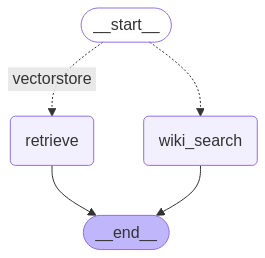

In [71]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [104]:
from pprint import pprint

# Run
inputs = {"question": "Where is india"}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}': ")
        
        # To print full state at each node
        # pprint(value["keys"], indent=2, width=100, depth = None)
        
    pprint("\n --- \n")
    
# Final Generation
pprint(value)

Routing question ....
Searching Wikipedia ....
"Node 'wiki_search': "
'\n --- \n'
{'documents': [Document(metadata={}, page_content='Page: India\nSummary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country from June 2023 onwards; and since its in')],
 'question': 'Where is india'}


In [103]:
from pprint import pprint

# Run
inputs = {"question": "Langgraph why?"}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}': ")
        
        # To print full state at each node
        # pprint(value["keys"], indent=2, width=100, depth = None)
        
    pprint("\n --- \n")
    
# Final Generation
pprint(value)

Routing question ....
Retriving ....
"Node 'retrieve': "
'\n --- \n'
{'documents': [Document(id='bb80d5231cdd4f258303a0fd52c9fc9a', metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics'}, page_content="2. Recent updates and features of LangGraph include:\n\n   a. LangGraph Cloud: This seems to be a cloud-based version of LangGraph, though specific details weren't provided in the search results.\n\n   b. LangGraph Platform: This is a newly introduced concept that combines several offerings:\n      - LangGraph Server\n      - LangGraph Studio\n      - CLI (Command Line Interface)\n      - SDK (Software Development Kit)\n\n3. LangGraph Server: This component has received new features to enhance its value proposition, though the specific features weren't detailed in the search results.\n\n4. LangGraph Studio: This appears to be a new tool in the LangGraph ecosys